# Introduction
Modified from https://www.kaggle.com/mathormad/pretrained-resnet50-focal-loss/notebook?scriptVersionId=12746542
(we have tried to catch up the Pytorch :) To see all my personal modification, please use `diff` from the original kernel to the latest version.

The best score is at version 17. But that version used `ResNet50` instead of 'should-be-better' `ResNet50V2`

In the current version, I try to improve the performance by change back from `DenseNet121` to `ResNet50`. For the previous DenseNet version with Acknowledgement, please take a look at version 9.

### Modification list

### ResNet50 Change LOG
* V13 [LB553, CV546] PixSize224, LR1e-4, Batch64, 2048Dense-Head, 30Epochs
* V14 [LB, CV549] Try VALID_SPLIT0.1, 29Epochs
* V15 Try batch96 << runtime exceed, from LOG file, there is a memory issue that degrades performance too
* V16 [CV528] Batch32, Epoch24 << finish too early & final LR too small
* V17 [CV551, LB560] Batch88, Epoch27 
* V18 [CV Bad] gamma=3
* V19 [CV Bad] gamma=4
* V20 [CV 524] change back to gamma=1 and use ResNetV2 weights -- thanks @mathormad again!
* V21[CV 381!] change Hyperparameter
* V22[CV526] batch64, LR1e-4
* V23[CV511] batch48, LR8e-5
* V24 Fix bugs on f2, my_f2 functions, try a bit deeper head to digest more information at the end
* V25-27 try V17 again [FAILED]
* V28 [] make a 'variable-size' input augmentation modification (resize later) - ResNetV1
* V28-34 Bugs
* V34 Bug Fixed [V2]
* V35-36[CV558 / 531] increase LR, adjust ReduceOnPlateau for both V1&V2 -- After play around with Lopuhin's great kernel on pytorch, I try to make a learning process converge faster and better << Better results
* V37-38 increase LR a bit more to force the network to converge earlier

** ToDo ** Deal with this issue : http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resnet50', 'densenet-keras', 'keras-pretrain-model-weights', 'imet-2019-fgvc6']


In [9]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score
from keras.utils import Sequence
WORKERS = 2
CHANNEL = 3
NUM_CLASSES = 1103

import warnings
warnings.filterwarnings("ignore")
SIZE = 224

RESNET_VER = 2 # Choose between V1 and V2
epochs = 27
batch_size = 88
SPLIT_RATIO = 0.1
POST_PROCESS = False
LR = 5e-4
LR_FACTOR = 0.2
PATIENCE=2
LR_WARM = 1e-3
gamma = 0.0 # focal loss
checkpoint_file = '../working/resnet50_focal.h5'

ModuleNotFoundError: No module named 'skimage'

In [11]:
! pip install scikit-image

  Stored in directory: C:\Users\icech\AppData\Local\pip\Cache\wheels\de\63\64\3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
!ls ../input

densenet-keras	imet-2019-fgvc6  keras-pretrain-model-weights  resnet50


In [4]:
# Load dataset info
path_to_train = '../input/imet-2019-fgvc6/train/'
data = pd.read_csv('../input/imet-2019-fgvc6/train.csv')

train_dataset_info = []
for name, labels in zip(data['id'], data['attribute_ids'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [6]:
!pip install tqdm

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [7]:
# https://www.kaggle.com/lopuhin/imet-2019-submission/output
import argparse
from collections import defaultdict, Counter
import random

import pandas as pd

DATA_ROOT = '../data/input/imet-2019-fgvc6/'


def make_folds(n_folds: int) -> pd.DataFrame:
    df = pd.read_csv(DATA_ROOT+ 'train.csv')
    cls_counts = Counter(cls for classes in df['attribute_ids'].str.split()
                         for cls in classes)
    #dictの型を先に宣言して初期化
    fold_cls_counts = defaultdict(int)
    folds = [-1] * len(df)
    for item in tqdm(df.sample(frac=1, random_state=42).itertuples(),
                          total=len(df)):
        cls = min(item.attribute_ids.split(), key=lambda cls: cls_counts[cls])
        fold_counts = [(f, fold_cls_counts[f, cls]) for f in range(n_folds)]
        min_count = min([count for _, count in fold_counts])
        random.seed(item.Index)
        fold = random.choice([f for f, count in fold_counts
                              if count == min_count])
        folds[item.Index] = fold
        for cls in item.attribute_ids.split():
            fold_cls_counts[fold, cls] += 1
    df['fold'] = folds
    return df

In [8]:
make_folds(1)

NameError: name 'tqdm' is not defined

In [6]:

epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

In [7]:
beta_f2=2

# if gamma == 0.0:
#     F2_THRESHOLD = 0.1
# elif gamma == 1.0:
#     F2_THRESHOLD = 0.2
# else:
#     F2_THRESHOLD = 0.3

# print(F2_THRESHOLD)
    
def f2(y_true, y_pred):
    #y_pred = K.round(y_pred)
#     y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), F2_THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + K.epsilon())
    f2 = tf.where(tf.is_nan(f2), tf.zeros_like(f2), f2)
    return K.mean(f2)

In [8]:
from keras.applications.resnet50 import preprocess_input

class data_generator(Sequence):
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                        
#                     image = cv2.resize(image, (SIZE, SIZE)) # resize later
                    batch_images.append(preprocess_input(image))
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                    
                yield np.array(batch_images, np.float32), batch_labels

    def create_valid(dataset_info, batch_size, shape, augument=False):
        assert shape[2] == 3
        while True:
            # dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), NUM_CLASSES))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if augument:
                        image = data_generator.augment(image)
                        
#                     image = cv2.resize(image, (SIZE, SIZE)) # resize later
                    batch_images.append(preprocess_input(image))
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels


    def load_image(path, shape):
        image = cv2.imread(path+'.png')
        image = cv2.resize(image, (SIZE, SIZE)) # resize later
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.SomeOf((0,4),[
#             iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
                iaa.Crop(percent=(0, 0.25)),
                iaa.ContrastNormalization((0.8, 1.2)),
                iaa.Multiply((0.9, 1.1), per_channel=0.2),
                iaa.Fliplr(0.5),
#                 iaa.GaussianBlur(sigma=(0, 0.6)),
#                 iaa.Affine(
#                         scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
#                         translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
#                         rotate=(-180, 180),
#                     )
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,GlobalAveragePooling2D,
                          BatchNormalization, Input, Conv2D, Concatenate)
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [10]:
from keras_applications import imagenet_utils as utils

def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils
    # backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    backend, layers, models, keras_utils = keras.backend, keras.layers, keras.models, keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = utils._obtain_input_shape(input_shape,
                                          default_size=224,
                                          min_size=32,
                                          data_format=backend.image_data_format(),
                                          require_flatten=include_top,
                                          weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                      name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,
                                            BASE_WEIGHTS_PATH + file_name,
                                            cache_subdir='models',
                                            file_hash=file_hash)
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                       name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,
                                 name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False,
                      name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride,
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x


def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.
    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x

def ResNet50V2(include_top=True,
               weights='imagenet',
               input_tensor=None,
               input_shape=None,
               pooling=None,
               classes=1000,
               **kwargs):
    def stack_fn(x):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',
                  include_top, weights,
                  input_tensor, input_shape,
                  pooling, classes,
                  **kwargs)

In [12]:
!ls ../input/keras-pretrain-model-weights

NASNet-large.h5
NASNet-mobile.h5
densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5
densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5
densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5
mobilenet_1_0_224_tf_no_top.h5
mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5
resnext101_weights_tf_dim_ordering_tf_kernels_notop.h5
resnext50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [13]:
!ls ../input/resnet50

imagenet_class_index.json
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [14]:
from keras.applications.resnet50 import ResNet50


# pretrained model is of 3 channels
def create_model_resnet50(n_out=NUM_CLASSES):
    print(RESNET_VER)
    if RESNET_VER == 1:
        base_model =ResNet50(weights=None, include_top=False)
        base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    else:
        base_model =ResNet50V2(weights=None, include_top=False)
        base_model.load_weights('../input/keras-pretrain-model-weights/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    x0 = base_model.output
    x1 = GlobalAveragePooling2D()(x0)
    x2 = GlobalMaxPooling2D()(x0)
    x = Concatenate()([x1,x2])
    
    x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    predictions = Dense(n_out, activation='sigmoid')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [16]:
# create callbacks list
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)
                             
from sklearn.model_selection import train_test_split

checkpoint = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=PATIENCE, 
                                   verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-5)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)


# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
train_indexes, valid_indexes = train_test_split(indexes, test_size=SPLIT_RATIO, random_state=8)

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
train_generator_warmup = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=False)
validation_generator = data_generator.create_valid(
    train_dataset_info[valid_indexes], batch_size, (SIZE,SIZE,3), augument=False)

# callbacks_list = [checkpoint, csv_logger, lrsched]
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat]

In [17]:
print(np.ceil(float(len(train_indexes)) / float(batch_size)))
print(np.ceil(float(len(valid_indexes)) / float(batch_size)))
print(len(train_indexes), batch_size)

1118.0
125.0
98313 88


In [18]:

# %%script false
model.fit_generator(
    train_generator_warmup,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    epochs=1,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1118/1118 [==============================] - 658s 589ms/step - loss: 0.0753 - acc: 0.9691 - f2: 0.0704


In [19]:
print(K.eval(model.optimizer.lr))

0.001


In [20]:

for layer in model.layers:
    layer.trainable = True

model.compile(# loss='binary_crossentropy',
            loss=focal_loss,
            optimizer=Adam(lr=LR),
            metrics=['acc',f2])

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    max_queue_size=16, workers=WORKERS, use_multiprocessing=True,
    callbacks=callbacks_list)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/27
1118/1118 [==============================] - 967s 865ms/step - loss: 14.6606 - acc: 0.1078 - f2: 0.1096 - val_loss: 14.5705 - val_acc: 0.0800 - val_f2: 0.0695

Epoch 00001: val_loss improved from inf to 14.57047, saving model to ../working/resnet50_focal.h5
Epoch 2/27
1118/1118 [==============================] - 934s 835ms/step - loss: 14.7307 - acc: 0.1081 - f2: 0.1010 - val_loss: 14.6858 - val_acc: 0.0822 - val_f2: 0.0789

Epoch 00002: val_loss did not improve from 14.57047
Epoch 3/27
1118/1118 [==============================] - 948s 848ms/step - loss: 14.0005 - acc: 0.1257 - f2: 0.1209 - val_loss: 16.8826 - val_acc: 0.1239 - val_f2: 0.1135

Epoch 00003: val_loss did not improve from 14.57047

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/27
1118/1118 [==============================] - 943s 843ms/step - loss: 13.1634 - acc: 0.1520 - f2: 0.1475 - val_loss

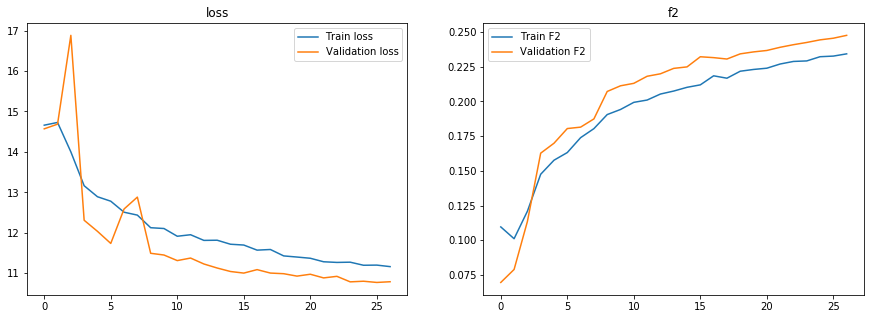

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('f2')
ax[1].plot(hist.epoch, hist.history["f2"], label="Train F2")
ax[1].plot(hist.epoch, hist.history["val_f2"], label="Validation F2")
ax[0].legend()
ax[1].legend()

In [22]:
print(K.eval(model.optimizer.lr))

1e-05


In [23]:
print(os.listdir('../working/'))
model.load_weights(checkpoint_file)

['training_log.csv', '__notebook__.ipynb', '__output__.json', 'resnet50_focal.h5']


In [24]:
'''Search for the best threshold regarding the validation set'''

BATCH = 512
fullValGen = data_generator.create_valid(
    train_dataset_info[valid_indexes], BATCH, (SIZE,SIZE,3))

n_val = round(train_dataset_info.shape[0]*0.2)//BATCH
print(n_val)

lastFullValPred = np.empty((0, NUM_CLASSES))
lastFullValLabels = np.empty((0, NUM_CLASSES))
for i in tqdm(range(n_val+1)): 
    im, lbl = next(fullValGen)
    scores = model.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

  0%|          | 0/43 [00:00<?, ?it/s]

42


100%|██████████| 43/43 [03:09<00:00,  4.59s/it]

(21676, 1103) (21676, 1103)


In [25]:
def my_f2(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]

    tp = np.sum((y_true == 1) & (y_pred == 1),axis=1)
    tn = np.sum((y_true == 0) & (y_pred == 0),axis=1)
    fp = np.sum((y_true == 0) & (y_pred == 1),axis=1)
    fn = np.sum((y_true == 1) & (y_pred == 0),axis=1)
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta_f2**2)*p*r / (p*beta_f2**2 + r + 1e-15)

    return np.mean(f2)

def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in tqdm(thrs):
        score.append(my_f2(targs, (preds > thr).astype(int) ))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

100%|██████████| 50/50 [00:21<00:00,  2.40it/s]


thr=0.080 F2=0.457


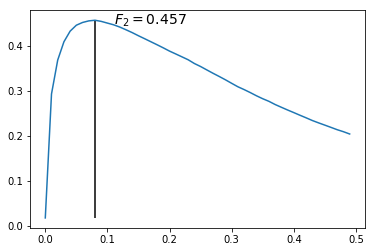

In [26]:
best_thr, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

In [27]:
submit = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')
predicted = []

for i, name in tqdm(enumerate(submit['id'])):
    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))
    score_predict = model.predict(preprocess_input(image[np.newaxis]))
    # print(score_predict)
    label_predict = np.arange(NUM_CLASSES)[score_predict[0]>=best_thr]
    # print(label_predict)
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

7443it [02:13, 55.68it/s]


In [28]:
submit['attribute_ids'] = predicted
if POST_PROCESS:
    submit.to_csv('submission_not_process.csv', index=False)
else:
    submit.to_csv('submission.csv', index=False)

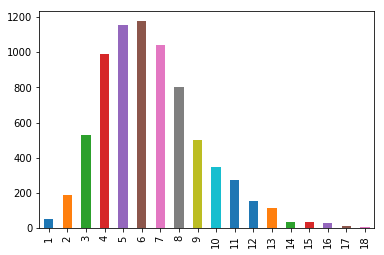

In [29]:
submit2 = submit.copy()
submit2.n_cate = submit.attribute_ids.apply(lambda x: len(x.split(" ")))
_ = submit2.n_cate.value_counts().sort_index().plot.bar()

In [30]:
id_rare = set([199,81,221,230,366,11,104,396,262,805,112,146,281,
               293,328,987,71,271,201,240,108,142,389,904,312,187])

id_bool = (lastFullValPred[0] > 2) # all False
print(sum(id_bool))
for ii in id_rare:
    id_bool[ii] = True
print(sum(id_bool))

lastFullValPred2 = lastFullValPred.copy()

lastFullValPred2[0][id_bool] = 0
thresh = np.percentile(lastFullValPred2[0],99.2)
print(sum(lastFullValPred2[0] < thresh))
lastFullValPred2[0][lastFullValPred2[0] < thresh] = 0
print(sum(lastFullValPred2[0] == 0))

0
26
1094
1094


In [31]:
print(lastFullValPred2[0].shape, (lastFullValPred2[i] < 0.1).shape)
lastFullValPred2 = lastFullValPred.copy()
for i in tqdm(range(len(lastFullValPred2))):
    lastFullValPred2[i][id_bool] = 0
    thresh = np.percentile(lastFullValPred2[i],99.2)
    lastFullValPred2[i][lastFullValPred2[i] < thresh] = 0

(1103,) (1103,)


100%|██████████| 21676/21676 [00:02<00:00, 8194.09it/s]


100%|██████████| 50/50 [00:21<00:00,  2.39it/s]

thr=0.080 F2=0.457


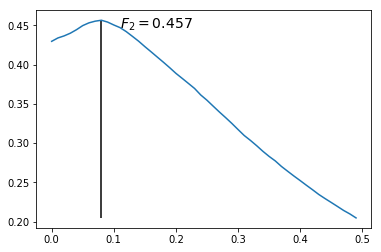

In [32]:
best_thr, best_score = find_best_fixed_threshold(lastFullValPred2, lastFullValLabels, do_plot=True)

In [33]:
%%time
submit = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')
predicted_post = []

for i, name in tqdm(enumerate(submit['id'])):
    path = os.path.join('../input/imet-2019-fgvc6/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))
    score_predict = model.predict(preprocess_input(image[np.newaxis]))
    
    thresh = np.percentile(score_predict,99.2)
    score_predict[score_predict < thresh] = 0
    
    
    # print(score_predict)
    label_predict = np.arange(NUM_CLASSES)[score_predict[0]>=best_thr]
    # print(label_predict)
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted_post.append(str_predict_label)

7443it [02:06, 58.78it/s]

CPU times: user 1min 29s, sys: 35.7 s, total: 2min 5s
Wall time: 2min 6s


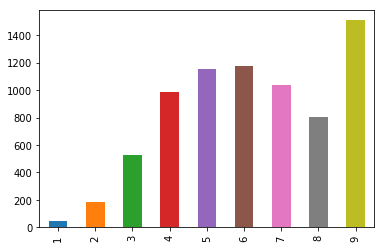

In [34]:
submit['attribute_ids'] = predicted_post
if POST_PROCESS:
    submit.to_csv('submission.csv', index=False)
else:
    submit.to_csv('submission_post_process.csv', index=False)

submit2 = submit.copy()
submit2.n_cate = submit.attribute_ids.apply(lambda x: len(x.split(" ")))
_ = submit2.n_cate.value_counts().sort_index().plot.bar()